In [45]:
from load_data import load_breast_cancer_data, load_mushroom_data, load_wine_quality_data

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import numpy as np

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading and preprocessing
Let's load the data, standardize it and split it into training and test sets.

In [46]:
# Read data
X, y = load_breast_cancer_data('../data/breast-cancer-wisconsin-data/data.csv')
#X, y = load_mushroom_data('../data/mushroom-classification/mushrooms.csv')
#X, y = load_wine_quality_data('../data/wine-quality/winequality-white.csv')
print('Total number of examples in the dataset: %d' % X.shape[0])
print('Fraction of positive examples: %.2f%%' % (y[y == 1].shape[0]/y.shape[0]*100.0))

# Standardize data
X = preprocessing.scale(X)

# Split into training and test data. Use random_state to get the same results in every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=18)

# Data structures for storing best accuracies, training time and test time
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

Total number of examples in the dataset: 569
Fraction of positive examples: 37.26%


The fraction of positive examples suggests that our data is not too unbalanced.

# Decision tree
Let's first train a decision tree without any optimization to get a feel for its performance on the given data.

In [51]:
clf_dt = tree.DecisionTreeClassifier(random_state=7)
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree without hyperparameter tuning is %.2f%%' % (dt_accuracy*100))

Accuracy of decision tree without hyperparameter tuning is 92.98%


## Validation curve
We will use a form of pre-pruning to prevent overfitting. Performance of a decision tree is affected by its maximum depth. A tree with a large depth will try to fit the training data exactly and is likely to result in overfitting. Let's plot the training and cross-validation scores to get a sense of how much the tree overfits with an increase in the depth.

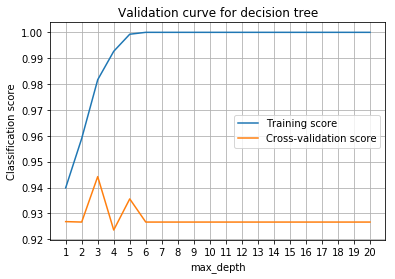

In [52]:
depth_range = np.arange(20) + 1
train_scores, test_scores = validation_curve(clf_dt, X_train, y_train, param_name="max_depth", param_range=depth_range, cv=5)

plt.figure()
plt.xticks(depth_range)
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

For low values of max_depth, the tree is excessively pruned and thus suffers from underfitting as both the training and cross-validation scores are low. The training score keeps increasing as max_depth increases. However, the cross-validation score first increases but starts decreasing at a certain point. This is where the tree starts to overfit.

## Hyperparameter tuning
Based on the validation curve above, we will define an appropriate grid for max_depth, tune it and find out the best accuracy using a decision tree.

In [53]:
depth_range = np.arange(10) + 1
tuned_params = {'max_depth' : depth_range}
clf_dt = GridSearchCV(clf_dt, param_grid=tuned_params, cv=5)
t0 = time.time()
clf_dt.fit(X_train, y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_dt = clf_dt
best_dt_params = clf_dt.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)
t0 = time.time()
y_pred = clf_dt.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

Completed training in 0.201874 seconds
Best parameters set for decision tree found on development set:
{'max_depth': 3}
Inference time on test data: 0.000000 seconds
Accuracy of decision tree is 92.98%


Even a tree with a depth as low as 3 can give the best performance on a dataset. Shorter trees also result in lower inference times.

## Learning curve

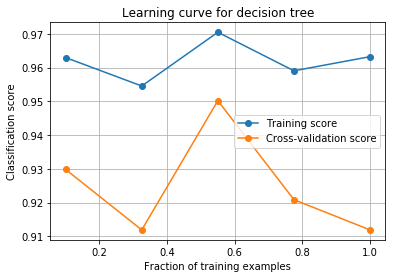

In [54]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_dt, X_train, y_train, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

There is a big difference between the training and cross-validation scores at the maximum data size. This suggests that the classifier is suffering from high variance and we will likely benefit from more training data.

# Neural network
For ease of analysis, we will experiment with a small neural network with 2 hidden layers containing 5 and 2 nodes respectively. Let's first evaluate the performance of the network without any hyperparameter tuning.

In [62]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1000)
clf_nn.fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network without hyperparameter tuning is 96.49%


This is the best accuracy so far, even without any hyperparameter tuning!

## Validation curve
Performance of a neural network is very sensitive to its learning rate and regularization parameter. Let's get a feel for it by plotting validation curves for both the parameters.

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

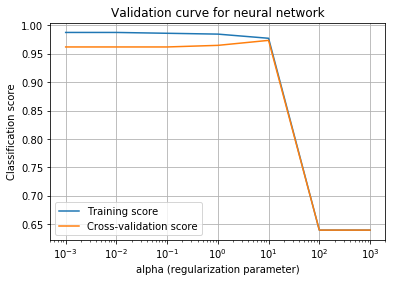

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

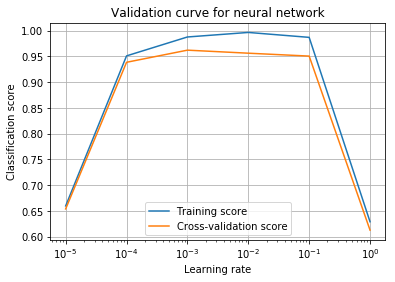

In [56]:
# Regularization parameter
alpha_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="alpha", param_range=alpha_range, cv=5)

plt.figure()
plt.semilogx(alpha_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(alpha_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('alpha (regularization parameter)')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Learning rate
lr_range = np.logspace(-5, 0, 6)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="learning_rate_init", param_range=lr_range, 
                                             cv=5)

plt.figure()
plt.semilogx(lr_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(lr_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('Learning rate')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_2.png')
plt.show()

## Hyperparameter tuning
Based on the validation curves plotted above, we will define an appropriate grid for each parameter and tune them.

In [63]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5)
t0 = time.time()
clf_nn.fit(X_train, y_train)
t1 = time.time()
train_time[1] = t1 - t0
print('Completed training in %f seconds' % train_time[1])
best_clf_nn = clf_nn
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

Completed training in 77.664397 seconds
Best parameters set found on development set:
{'alpha': 3.1622776601683795, 'learning_rate_init': 0.1}


## Learning curve

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\s

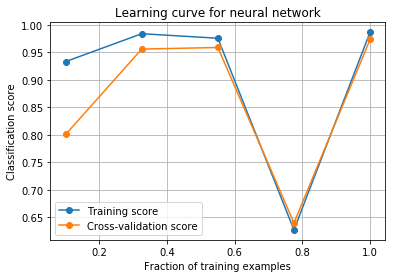

In [58]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_nn, X_train, y_train, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for neural network')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

Both training and cross-validation scores are high at the maximum training data size. Hence, there is neither high bias nor high variance and the classifier is performing well.

## Loss curves
We will now observe how training error decreases with epochs.

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of neural network is 97.81%


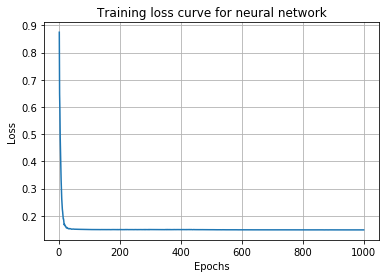

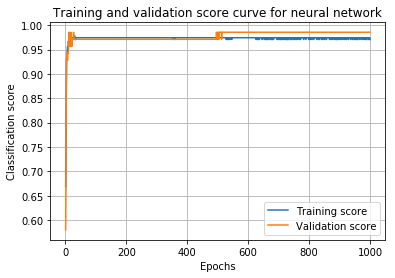

In [59]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1, warm_start=True)
clf_nn.set_params(alpha=best_params['alpha'], learning_rate_init=best_params['learning_rate_init'])
num_epochs = 1000
train_loss = np.empty(num_epochs)
train_scores = np.empty(num_epochs)
val_scores = np.empty(num_epochs)
# Split training set into training and validation
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=18)
for i in range(num_epochs):
    clf_nn.fit(X_train1, y_train1)
    train_loss[i] = clf_nn.loss_
    train_scores[i] = accuracy_score(y_train1, clf_nn.predict(X_train1))
    val_scores[i] = accuracy_score(y_val, clf_nn.predict(X_val))

y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network is %.2f%%' % (nn_accuracy * 100))

xrange = np.arange(num_epochs) + 1
plt.figure()
plt.plot(xrange, train_loss)
plt.title('Training loss curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.grid()
#plt.savefig(fig_path + 'nn_train_loss.png')
plt.show()

plt.figure()
plt.plot(xrange, train_scores, label='Training score')
plt.plot(xrange, val_scores, label='Validation score')
plt.title('Training and validation score curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Classification score")
plt.grid()
plt.legend(loc="best")
#plt.savefig(fig_path + 'nn_score_curve.png')
plt.show()

Training loss decreases with epochs and then converges to a low value. The validation score is high when training has converged, indicating that the network is performing well.

## Evaluate optimal model
Let's find the test accuracy of the neural network with its hyperparameters tuned to their optimal values.

In [64]:
t0 = time.time()
y_pred = best_clf_nn.predict(X_test)
t1 = time.time()
test_time[1] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[1])
best_accuracy[1] = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy[1] * 100))

Inference time on test data: 0.000000 seconds
Best accuracy of neural network is 98.25%


Among the classifiers we have seen so far, neural network is performing the best.

# Boosting
We will use AdaBoost with decision stumps.

In [65]:
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, random_state=7)
clf_boosted.fit(X_train, y_train)
y_pred = clf_boosted.predict(X_test)
boosted_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost without hyperparameter tuning is %.2f%%' % (boosted_accuracy * 100))

Accuracy of Adaboost without hyperparameter tuning is 96.49%


## Validation curve
Number of weak learners is a hyperparameter we have to tune. To understand how it affects the performance of the classifier, we will plot training and cross-validation scores wrt the number of learners.

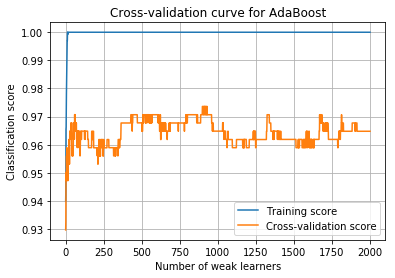

In [66]:
# Define AdaBoost learner
num_learners = 2000
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners, random_state=7)

# Cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=7)
train_scores = np.zeros((num_learners, num_folds))
val_scores = np.zeros((num_learners, num_folds))
for idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    clf_boosted.fit(X_train[train_index], y_train[train_index])
    train_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[train_index], y_train[train_index])))
    val_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[test_index], y_train[test_index])))

n_estimators_range = np.arange(num_learners) + 1
plt.figure()
plt.plot(n_estimators_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_estimators_range, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Cross-validation curve for AdaBoost')
plt.xlabel('Number of weak learners')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

## Evaluate optimal model
As we can observe in the above plot, the training accuracy first increases with an increase in the number of weak learners and then converges to 1. The cross-validation score also increases and attains its maximum somewhere between 750 and 1000. There are some fluctuations in the cross-validation as the number of learners increases but they are small. This is because boosting is empirically resistant to overfitting. It continues to drive down the test error even after the training error reaches zero.

Let's find the optimal number of learners and report test accuracy with that.

In [67]:
num_learners_optimal = np.argmax(np.mean(val_scores, axis=1)) + 1
print('Optimal number of learners for AdaBoost: %d' % num_learners_optimal)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
t0 = time.time()
best_clf_boosted.fit(X_train, y_train)
t1 = time.time()
train_time[2] = t1 - t0
print('Completed training in %f seconds' % train_time[2])
t0 = time.time()
y_pred = best_clf_boosted.predict(X_test)
t1 = time.time()
test_time[2] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[2])
best_accuracy[2] = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost with the best hyperparameters is %.2f%%' % (best_accuracy[2] * 100))

Optimal number of learners for AdaBoost: 899
Completed training in 2.384524 seconds
Inference time on test data: 0.111929 seconds
Accuracy of Adaboost with the best hyperparameters is 97.37%


## Learning curve

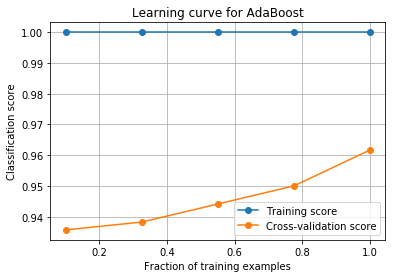

In [68]:
train_sizes = np.linspace(0.1, 1.0, 5)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
_, train_scores, test_scores = learning_curve(best_clf_boosted, X_train, y_train, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for AdaBoost')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

As we can observe in the learning curve plotted above, cross-validation score increases with an increase in the training data size. This can be explained by a property of boosting according to which it can fail if the given data is insufficient. The training score is 1 as boosting learns the training data exactly after a sufficient number of rounds. Since there is a gap between the training and cross-validation scores at the maximum training data size, more training data is likely to improve cross-validation score further.

# SVM
We will use an SVM with a linear kernel.

In [69]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Validation curve
Let's plot the training and cross-validation scores wrt the penalty parameter $C$ (which controls regularization).

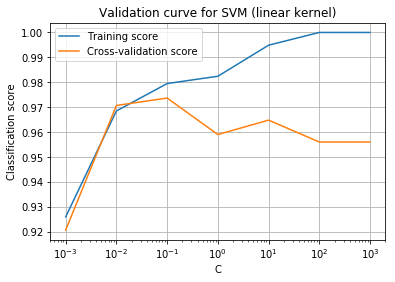

In [70]:
C_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(svm_linear, X_train, y_train, param_name="C", param_range=C_range, cv=5)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

As we can observe in the validation curve plotted above, both training and cross-validation scores first increase as C increases. However, after $C = 10^{-1}$, training score continues to increase while cross-validation score decreases, indicating overfitting.

# Hyperparameter tuning
Based on the validation curve plotted above, we will now define an appropriate grid for $C$ and tune it.

In [71]:
C_range = np.logspace(-2, 1, 10)
tuned_params = {'C' : C_range}
svm_linear = GridSearchCV(svm_linear, param_grid=tuned_params, cv=5)
t0 = time.time()
svm_linear.fit(X_train, y_train)
t1 = time.time()
train_time[3] = t1 - t0
print('Completed training in %f seconds' % train_time[3])
best_clf_svm = svm_linear
best_params = svm_linear.best_params_
print("Best parameters set found on development set:")
print(best_params)
t0 = time.time()
y_pred = best_clf_svm.predict(X_test)
t1 = time.time()
test_time[3] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[3])
best_accuracy[3] = accuracy_score(y_test, y_pred)
print('Best accuracy with SVM (linear kernel) is %.2f%%' % (best_accuracy[3] * 100))

Completed training in 0.169895 seconds
Best parameters set found on development set:
{'C': 0.1}
Inference time on test data: 0.001000 seconds
Best accuracy with SVM (linear kernel) is 97.37%


# Learning curve

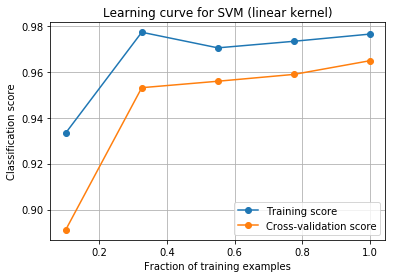

In [72]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_svm, X_train, y_train, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for SVM (linear kernel)')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

From the learning curve, we can observe that SVM works well even with a small amount of data. The accuracy increases with the number of training examples and is still increasing when the training data size is at its maximum. Cross-validation accuracy hasn't converged to the training accuracy, indicating high variance. This suggests that test accuracy may improve further if more training data is added.

# kNN

## Validation curve
Let's find out how the accuracies are affected by the number of neighbors.

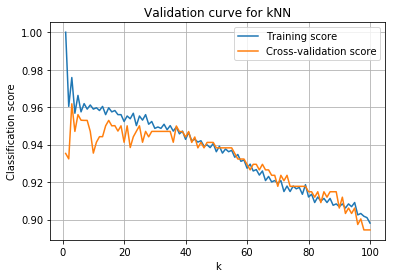

In [73]:
k_range = np.arange(1, 101)
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", 
                                             param_range=k_range, cv=5)

plt.figure()
plt.plot(k_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(k_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for kNN')
plt.xlabel('k')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

For low values of $k$, training score is high whereas cross-validation score is low, indicating that the model is suffering from high variance (overfitting). As $k$ increases, training score drops and cross-validation score increases. After a certain point, both the scores start dropping because of high bias (underfitting).

## Evaluate optimal model
We will choose the value of k which gives the best cross-validation score and evaluate test score with that.

In [74]:
k_optimal = np.argmax(np.mean(test_scores, axis=1)) + 1
print('Optimal value of k: %d' % k_optimal)
best_clf_knn = KNeighborsClassifier(n_neighbors=k_optimal)
t0 = time.time()
best_clf_knn.fit(X_train, y_train)
t1 = time.time()
train_time[4] = t1 - t0
print('Completed training in %f seconds' % train_time[4])
t0 = time.time()
y_pred = best_clf_knn.predict(X_test)
t1 = time.time()
test_time[4] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[4])
best_accuracy[4] = accuracy_score(y_test, y_pred)
print('Accuracy of kNN with k = %d is %.2f%%' % (k_optimal, best_accuracy[4] * 100))

Optimal value of k: 3
Completed training in 0.000999 seconds
Inference time on test data: 0.005998 seconds
Accuracy of kNN with k = 3 is 97.81%


## Learning curve

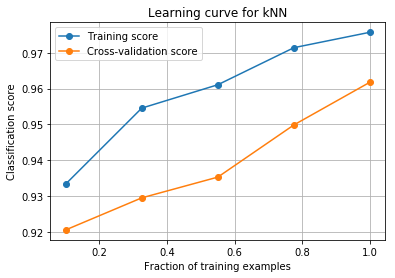

In [75]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_knn, X_train, y_train, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for kNN')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

Both training and cross-validation score increase with an increase in the number of training examples. As the training score is much greater than the validation score for the maximum training data size, adding more training data will most likely increase generalization as the classifier is suffering from high variance.

# Comparing the classifiers
We will now compare the 5 classifiers with respect to accuracy, training time and inference time.

In [88]:
classifiers = ('Decision tree', 'Neural network', 'AdaBoost', 'SVM', 'kNN')
y_pos = np.arange(len(classifiers))

## Accuracy

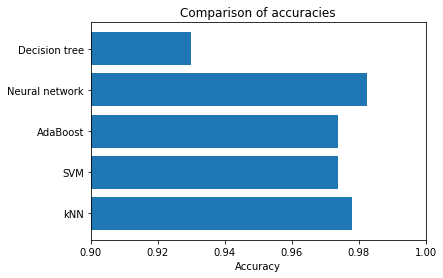

In [89]:
plt.figure()
plt.barh(y_pos, best_accuracy)
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of accuracies')
plt.xlabel('Accuracy')
plt.show()

Decision tree has the lowest test accuracy because it is the least expressive among the 5 models. Neural network is a powerful learning model and has the best accuracy. It is surprisingly followed by kNN. Adaboost and SVM have the least accuracy among the models which is counter-intuitive. One possible explanation is the amount of data --- the learning curves show that they can potentially improve if more training data is available.

## Training time

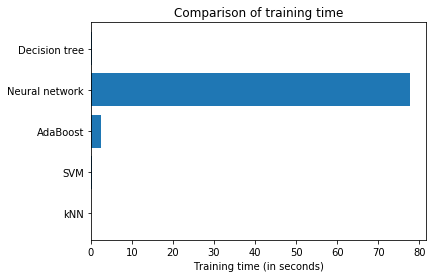

In [92]:
plt.figure()
plt.barh(y_pos, train_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of training time')
plt.xlabel('Training time (in seconds)')
plt.show()

Decision tree, SVM and kNN take a trivial amount of time to train. For the given dataset, the depth of the decision tree is low due to pre-pruning which is why training time is low. Training kNN is trivial since it just involves storing the training data. Training SVMs involves quadratic optimization which is faster than iterative algorithms such as neural network backpropogation or boosting. AdaBoost and neural network are the slowest with the latter being much slower than the former as gradient computations in backprop take longer than the weight updates in boosting.

## Inference time

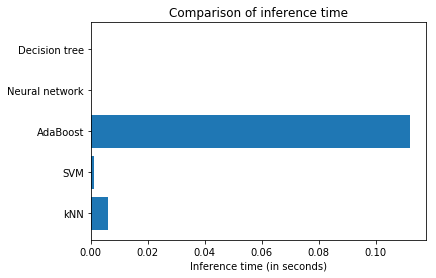

In [93]:
plt.figure()
plt.barh(y_pos, test_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of inference time')
plt.xlabel('Inference time (in seconds)')
plt.show()

Querying a decision tree is fast since it just involves tree traversal. Also, for the given dataset, the tree is shallow which also contributes to the speed. Querying a neural network is also fast as once the weights are computed, the forward pass is not computationally expensive. AdaBoost is the slowest for this dataset possibly because of the high number of learners. Linear SVMs are quite fast during inference as they just have to compute the value of a linear function. kNN inference is slow as it involves distance computation wrt each point in the training data.